# Supervised machine learning with Mol2vec

The notebooks illustrates how Mol2vec can be used to featurize and classify molecules using an Ames mutagenicity benchmark dataset by [Hansen et al.](http://pubs.acs.org/doi/abs/10.1021/ci900161g) as an example.
* [Featurize the molecules using pre-trained Mol2vec model](#Featurize-the-molecules-using-pre-trained-Mol2vec-model)
* [Train and validate Random Forest model trained using Mol2vec vectors](#Train-and-validate-Random-Forest-model-trained-using-Mol2vec-vectors)
* [Featurize molecules from the command line](#Featurize-molecules-from-the-command-line)

In [1]:
import sys

sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

Load the pre-processed [Ames](http://pubs.acs.org/doi/suppl/10.1021/ci900161g) dataset

In [3]:
df = PandasTools.LoadSDF('data/ames.sdf')

,class,ID,ROMol
0,0,2475-33-4,

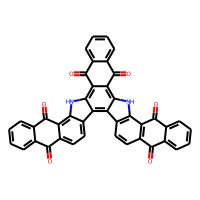

In [4]:
df.head(1)

In [5]:
len(df)

6506

### Featurize the molecules using pre-trained Mol2vec model

Load a pre-trained Mol2vec model which was trained on 20 million compounds downloaded from ZINC using:

* radius 1
* UNK to replace all identifiers that appear less than 4 times
* skip-gram and window size of 10
* resulting in 300 dimensional embeddings

In [6]:
model = word2vec.Word2Vec.load('models/model_300dim.pkl')

Generate "molecular sentences" that are then used to featurize the molecules (i.e. vectors of identifiers are extracted from Mol2vec model and summed up)

In [7]:
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

Extract the training data from the data frame

In [8]:
X = np.array([x.vec for x in df['mol2vec']])
y = np.array(df['class'].astype(int))

### Train and validate Random Forest model trained using Mol2vec vectors

Performance validation is done by stratified K-fold (4-fold CV) with shuffling

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [10]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [11]:
y_values = []
predictions = []
probas = []
for train, test in kf.split(X, y):
    clf = RandomForestClassifier(n_estimators=500, random_state=0)
    clf.fit(X[train], y[train])
    predictions.append(clf.predict(X[test]))
    probas.append(clf.predict_proba(X[test]).T[1]) # Probabilities for class 1
    y_values.append(y[test])
    del clf

Calculate performance metrics and plot them (ROC AUC)

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [13]:
aucs = [roc_auc_score(y, proba) for y, proba in zip(y_values, probas)]

In [14]:
np.mean(aucs), np.std(aucs)

(0.8686917091204087, 0.004411664917973581)

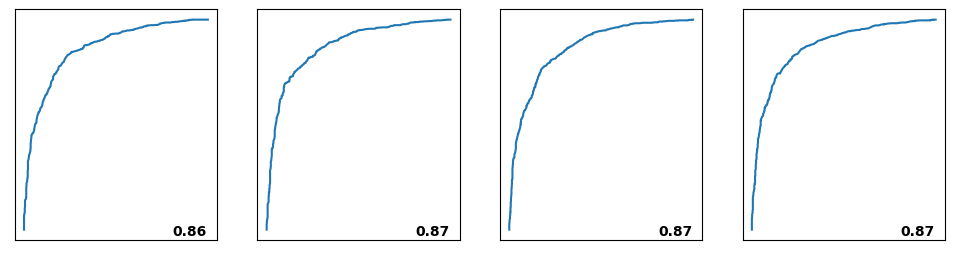

In [15]:
f, ((p1, p2, p3, p4)) = plt.subplots(1,4, squeeze=True, sharex=True, sharey=True, 
                                                    figsize=(12,3))

for y,proba,ax in zip(y_values, probas, (p1,p2,p3,p4)):
    tpr, fpr, _ = roc_curve(y, proba)
    auc = roc_auc_score(y, proba)
    ax.plot(tpr, fpr)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.95, 0.01, u"%0.2f" % auc,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, weight='bold',
            fontsize=10)
plt.show()

### Featurize molecules from the command line

Alternative to using Python functions is the command line `mol2vec` application. Type `mol2vec -h` for more information.

Calling command line application from Jupyter notebook

In [16]:
!mol2vec featurize -i data/ames.sdf -o data/ames.csv -m models/model_300dim.pkl --uncommon UNK -r 1 

zsh:1: command not found: mol2vec


Load embedding generated by the `mol2vec` application

In [17]:
df_2 = pd.read_csv('data/ames.csv', index_col=[0])

Not that unlike above where Mol2vec vectors are stored is data frame cells as DfVec objects command line application stores each dimension of the vectors as separate column (*mol2vec-000* to *mol2vec-n-dimensions*).

In [18]:
df_2.head()

,ID,class,Smiles,mol2vec-000,mol2vec-001,mol2vec-002,mol2vec-003,mol2vec-004,mol2vec-005,mol2vec-006,...,mol2vec-290,mol2vec-291,mol2vec-292,mol2vec-293,mol2vec-294,mol2vec-295,mol2vec-296,mol2vec-297,mol2vec-298,mol2vec-299
0,2475-33-4,0,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,5.456957,-4.577423,-12.368451,16.083830,-3.434435,7.834656,-19.782095,...,1.430486,26.688830,23.171576,-1.260016,-9.860835,-8.898393,-5.809005,-2.776645,-25.595627,3.428245
1,105149-00-6,0,CC(=O)OC1(C(C)=O)CCC2C3C=C(Cl)C4=CC(=O)OCC4(C)...,-1.448800,-4.337300,-5.178877,-1.282419,1.766603,-10.270999,-7.947514,...,-0.461931,16.831740,1.196181,0.779802,-11.972276,-11.135598,-7.943648,-0.847338,-12.080369,0.295639
2,108-78-1,0,Nc1nc(N)nc(N)n1,3.013881,-0.951261,-2.033241,5.549432,0.236704,1.911445,-5.053204,...,-0.225764,2.731790,3.982094,1.519018,-3.268411,-1.150581,-2.642860,0.724878,-5.361345,-0.026346
3,2425-85-6,1,Cc1ccc(N=Nc2c(O)ccc3ccccc23)c([N+](=O)[O-])c1,2.394809,0.218998,-4.836370,3.654727,-1.331921,2.192184,-12.556707,...,-2.438780,9.894881,10.634574,-0.291311,-5.443808,-0.568621,-5.671459,-1.188024,-6.807311,0.050133
4,67019-24-3,0,CC(C)CC(=O)Nc1snc2ccccc12,-0.494966,-1.786182,-2.199523,3.491824,1.604756,0.218301,-6.630700,...,2.209238,6.271803,6.540677,-0.264462,-4.927453,-0.989357,-2.540658,-3.798957,-6.871327,-0.260521


Extracting features for the machine learning

In [19]:
X = np.array(df_2[[x for x in df_2.columns if 'mol2vec' in x]])

In [20]:
X.shape

(6506, 300)